In [1]:
!pip install segment_anything

The “Fire” project conducted within the laboratory “Sciences Pour l’Environnement” UMR CNRS 6134 SPE - University of Corsica is dedicated to the modeling and experimentation of vegetation fires. One of the goals is measuring through vision the geometrical characteristics of fires.

As part of this research, a database has been developed. It contains wildfires pictures and image sequences acquired in the areas of visible and near-infrared in various conditions of shooting, type of burning vegetation, climatic conditions, brightness and distance to fire. Data are associated to each picture, for example a two-color image with the white pixels indicating the fire pixels selected manually, the dominant color of the fire, the percentage of fire pixels in the image, the percentage of fire pixels covered by smoke, the level of texture of the fire area are associated with each image, are associated to each picture.

In [2]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import glob
import matplotlib.pyplot as plt
import json
import toml
import os
import datetime

import cv2
import matplotlib.pyplot as pltntak
import numpy as np

import torchvision.transforms as transforms
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from torch.utils.data import DataLoader, Dataset
import logging
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

Load the data

In [3]:
from tqdm import tqdm
xfilenames = [img for img in glob.glob("/kaggle/input/corsica-fires/test/images/*.png")]
xfilenames.sort()
img_list=[]
i = 0
for name in tqdm(xfilenames):
  img=Image.open(name)
  img_list.append(img)
  if i == 1000:
    break
  else:
    i+=1
X_test = np.array(img_list)

 14%|█▍        | 1000/6954 [00:06<00:38, 154.02it/s]


In [4]:
filenames = [img for img in glob.glob("/kaggle/input/corsica-fires/test/masks/*.png")]
filenames.sort()
img_list=[]
j=0
for name in tqdm(filenames):
  img=Image.open(name)
  img_list.append(img)
  if j == 1000:
    break
  else:
    j+=1
Y_test = np.array(img_list)

 14%|█▍        | 1000/6954 [00:04<00:27, 218.08it/s]


In [5]:
print(X_test.shape)
print(Y_test.shape)

(1001, 256, 256, 3)
(1001, 256, 256, 3)


In [6]:
!pip install datasets

In [7]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in X_test],
    "label": [Image.fromarray(mask) for mask in Y_test],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [8]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1001
})

In [9]:
from PIL import Image
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader
import glob
sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth'
model_type = "vit_l" #
device = "cuda" #cpu,cuda

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)
predictor = SamPredictor(sam)

In [10]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

Automatic Mask Generation failed attempt 

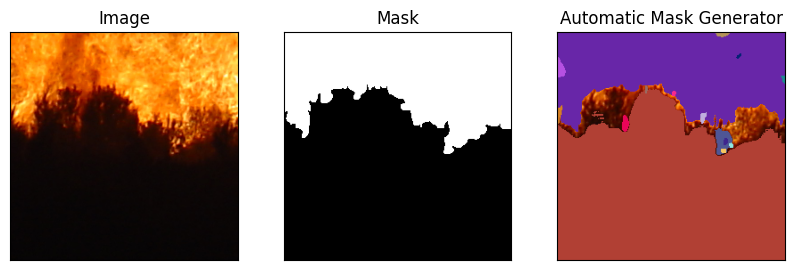

In [11]:
import random
img_num = random.randint(0, X_test.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")


masks = mask_generator.generate(np.array(example_image))
axes[2].imshow(example_image, cmap='gray')  # Assuming the second image is grayscale
show_anns(masks)
axes[2].set_title("Automatic Mask Generator")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [12]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [13]:
#Get input point from mask.
def get_input_point(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]
  x, y = (x_max-x_min)/2, (y_max-y_min)/2
  input = [[x,y]]
  return input

In [14]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt_box = get_bounding_box(ground_truth_mask[:,:,0])
    prompt = get_input_point(ground_truth_mask[:,:,0])
    #print(prompt_box)
    #print(prompt)
    # prepare image and prompt for the model
    inputs = self.processor(image, input_points=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [15]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

2024-05-27 11:24:47.951167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 11:24:47.951263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 11:24:48.054729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [16]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [17]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 1, 2])
ground_truth_mask (256, 256, 3)


In [18]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [19]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_points torch.Size([2, 1, 1, 2])
ground_truth_mask torch.Size([2, 256, 256, 3])


In [20]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256, 3])

In [21]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [22]:
!pip install -q monai

In [23]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.FocalLoss(reduction='mean')

**Training Loop**

In [57]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_points=batch["input_points"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks[:,0,:,:], ground_truth_masks[:,:,:,0])

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    print(outputs.iou_scores)

100%|██████████| 3477/3477 [37:02<00:00,  1.56it/s]


EPOCH: 0
Mean loss: 0.6596634112929994
tensor([[[0.5099]],

        [[0.4851]]], device='cuda:0', grad_fn=<SliceBackward0>)


100%|██████████| 3477/3477 [37:26<00:00,  1.55it/s]

EPOCH: 1
Mean loss: 0.11450878304926744
tensor([[[0.3806]],

        [[0.2995]]], device='cuda:0', grad_fn=<SliceBackward0>)


Saving the new model

In [58]:
# Save the model's state dictionary to a file
import pickle

Pkl_Filename = "Test_Model.pkl"

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(model, file)
    

**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:
    my_mito_model = pickle.load(file)

#my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_full_data_10_epochs_model_checkpoint.pth"))

In [60]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [61]:
xfilenames = [img for img in glob.glob("/kaggle/input/corsica-fires/test/images/*.png")]
xfilenames.sort()
img_list=[]
for name in tqdm(xfilenames):
  img=Image.open(name)
  img_list.append(img)
X_val = np.array(img_list)

100%|██████████| 6954/6954 [00:14<00:00, 467.17it/s]


In [62]:
filenames = [img for img in glob.glob("/kaggle/input/corsica-fires/test/masks/*.png")]
filenames.sort()
img_list=[]
for name in tqdm(filenames):
  img=Image.open(name)
  img_list.append(img)
Y_val = np.array(img_list)

100%|██████████| 6954/6954 [00:13<00:00, 524.37it/s]


In [63]:
from datasets import Dataset
# Convert the NumPy arrays to Pillow images and store them in a dictionary
val_dataset_dict = {
    "image": [Image.fromarray(img) for img in X_val],
    "label": [Image.fromarray(mask) for mask in Y_val],
}

# Create the dataset using the datasets.Dataset class
val_dataset = Dataset.from_dict(val_dataset_dict)

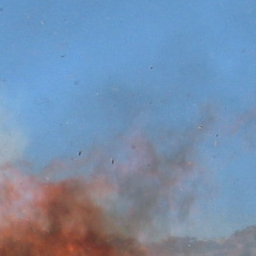

In [64]:
val_dataset[25]["image"]

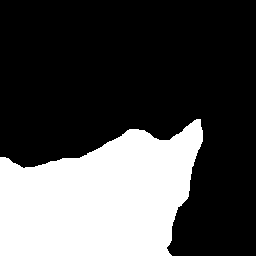

In [65]:
val_dataset[25]["label"]


The **sigmoid function** is commonly used in image segmentation tasks, particularly in the context of semantic segmentation or object detection, to generate pixel-wise probability maps. 
Before applying the sigmoid function, the output of the segmentation model usually consists of logits, which are raw scores produced by the model's last layer. These logits may not be directly interpretable as probabilities. The sigmoid function is applied to the logits to transform them into probabilities, mapping them to a probability scale with values between 0 and 1. 

After applying the sigmoid function, the output becomes pixel-wise probability maps. Each pixel in the probability map represents the likelihood of that pixel belonging to a certain class or object. In binary segmentation tasks, a value close to 1 indicates high confidence that the pixel belongs to the target class, while a value close to 0 indicates low confidence. Depending on the application, a threshold may be applied to the probability maps to obtain binary segmentation masks. Pixels with probabilities above a certain threshold are assigned to the target class, while pixels with probabilities below the threshold are considered background.


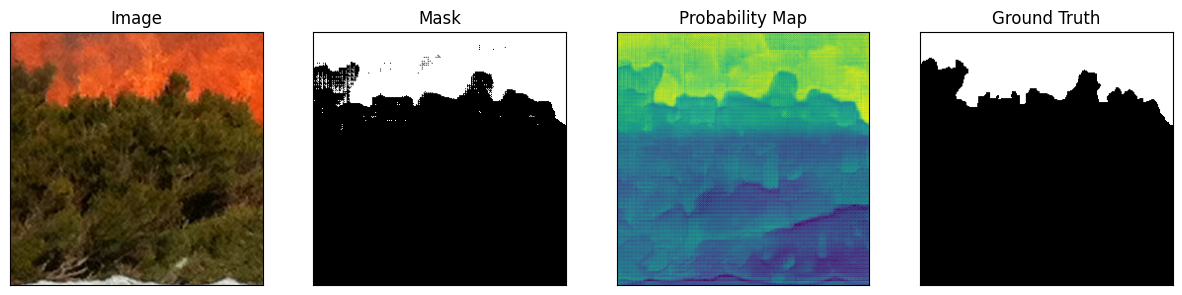

In [158]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = 18
# load image
test_image = val_dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(val_dataset[idx]["label"])
prompt_box = get_bounding_box(ground_truth_mask[:,:,0])
prompt = get_input_point(ground_truth_mask[:,:,0])
# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt_box]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.61).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(test_image, cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the second image on the right
axes[3].imshow(ground_truth_mask)  # Assuming the second image is grayscale

axes[3].set_title("Ground Truth")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    

# Display the images side by side
plt.show()


In [166]:
iou_list = []
for i in tqdm(range(len(X_val))):    
    # load image
    test_image = val_dataset[i]["image"]
    #print(test_image.size)
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(val_dataset[i]["label"])
    prompt_box = get_bounding_box(ground_truth_mask[:,:,0])
    prompt = get_input_point(ground_truth_mask[:,:,0])
    # prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt_box]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    my_mito_model.eval()

    # forward pass
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)

    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.55).astype(np.uint8)

    #truth = np.array(dataset[idx]["label"])[:,:,0]
    #truth = np.resize(truth, (truth.shape[0]*truth.shape[1],))
    #medsam_seg = np.resize(medsam_seg, (medsam_seg.shape[0]*medsam_seg.shape[1],))
    
    gt_mask = np.array(val_dataset[i]["label"])[:,:,0].astype(bool)
    predicted_mask = np.array(medsam_seg).astype(bool)
    # Calculate Intersection over Union (IoU)
    intersection = np.logical_and(gt_mask, predicted_mask)
    union = np.logical_or(gt_mask, predicted_mask)
    iou = np.sum(intersection) / np.sum(union)
    #print(iou)
    iou_list.append(iou)

100%|██████████| 6954/6954 [37:23<00:00,  3.10it/s]


In [165]:
mean(iou_list)

0.627922933686062

**CLIPSEG**

In [2]:
!pip install -q transformers

In [25]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


CLIPSegForImageSegmentation(
  (clip): CLIPSegModel(
    (text_model): CLIPSegTextTransformer(
      (embeddings): CLIPSegTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPSegEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPSegEncoderLayer(
            (self_attn): CLIPSegAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPSegMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=20

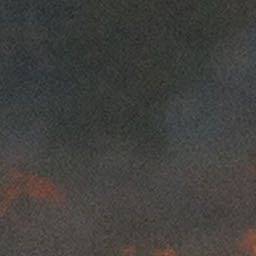

In [73]:
from PIL import Image
import requests

#url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
#image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('/kaggle/input/corsica-fires/test/images/1814_6_2.png')
image

Setup the Prompts

In [74]:
import torch
prompts = ["fire", "tree", "forest", "ground"]
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt").to(device)
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

Example 

123904
(256, 256)


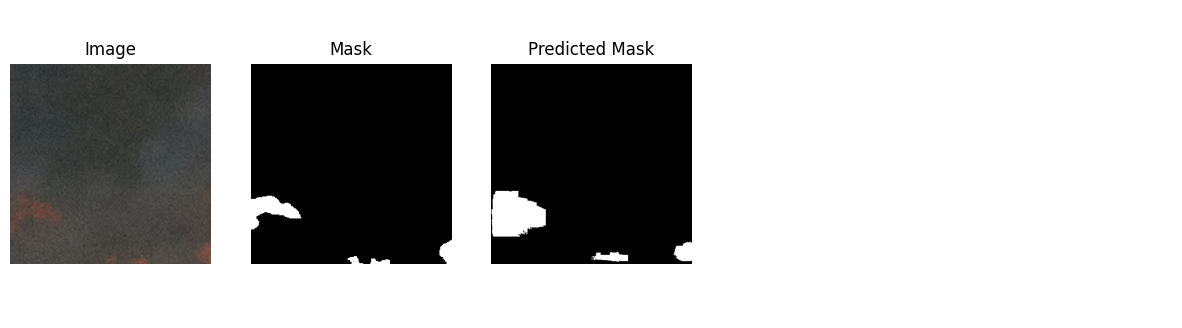

In [79]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[0].set_title("Image")
#[ax[i+1].imshow(torch.sigmoid(preds[i][0]).cpu()) for i in range(len(prompts))];
#[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];
medsam_seg_prob = torch.sigmoid(preds[0][0].squeeze(1))

medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.15).astype(np.uint8)
ax[2].imshow(medsam_seg, cmap='gray')
ax[2].set_title("Predicted Mask")

mask = Image.open('/kaggle/input/corsica-fires/test/masks/1814_6_2.png')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Mask")
print(medsam_seg.size)
print(mask.size)

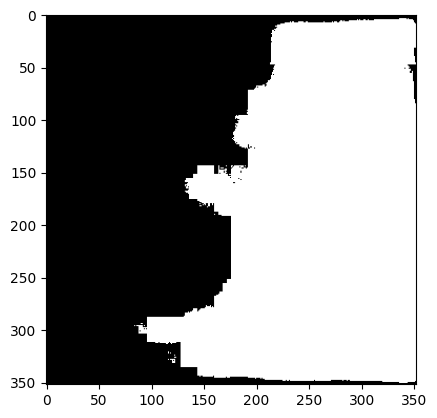

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# apply sigmoid


In [8]:
medsam_seg.shape

(352, 352)

In [18]:
mask = Image.open('/kaggle/input/corsica-fires/test/masks/1815_5_5.png')
mask = mask.resize((352,352))
gt_mask = np.array(mask)[:,:,0].astype(bool)
predicted_mask = np.array(medsam_seg).astype(bool)
# Calculate Intersection over Union (IoU)
intersection = np.logical_and(gt_mask, predicted_mask)
union = np.logical_or(gt_mask, predicted_mask)
iou = np.sum(intersection) / np.sum(union)
print(iou)

0.8650359294476301


**Training Loop**

In [182]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

images = [img for img in glob.glob("/kaggle/input/corsica-fires/test/images/*.png")]
images.sort()
masks = [mask for mask in glob.glob("/kaggle/input/corsica-fires/test/masks/*.png")]
masks.sort()
#Training loop
num_epochs = 2
prob = 0.14
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
seg_loss = monai.losses.FocalLoss(reduction='mean')
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for i in tqdm(range(len(Y_test))):
      # forward pass
      prompts = ["fire", "tree", "forest", "ground"]
      image = Image.open(images[i])
      inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt").to(device)
      # predict
      with torch.no_grad():
        outputs = model(**inputs)
      preds = outputs.logits.unsqueeze(1)
       # apply sigmoid
      #preds[0][0] = np.array(preds[0][0].cpu()).resize(256,256)
      medsam_seg_prob = torch.sigmoid(preds[0][0].squeeze(1))
      # convert soft mask to hard mask
      medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
      medsam_seg = torch.tensor((medsam_seg_prob > prob), dtype=torch.float) 
      # compute loss
      predicted_masks = medsam_seg
      #print((predicted_masks).shape)
      ground_truth_masks = Image.open(masks[i])
      ground_truth_masks = ground_truth_masks.resize((352,352))
      ground_truth_masks = torch.tensor(np.array(ground_truth_masks), dtype=torch.float) 
      #ground_truth_masks = ground_truth_masks.resize(2,352,352,3)
      #print(ground_truth_masks.shape)
      loss = seg_loss(predicted_masks, ground_truth_masks[:,:,0])

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.requires_grad = True
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')

100%|██████████| 6954/6954 [16:32<00:00,  7.01it/s]


EPOCH: 0
Mean loss: 0.20106182209765566


100%|██████████| 6954/6954 [16:31<00:00,  7.01it/s]

EPOCH: 1
Mean loss: 0.20106182209765566


In [183]:
# Save the model's state dictionary to a file
import pickle

Pkl_Filename = "Test_Model_fire.pkl"

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(model, file)

**Inference**

In [185]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import torch
# Load the model configuration

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create an instance of the model architecture with the loaded configuration
my_fire_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
#Update the model by loading the weights from saved file.
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:
    my_fire_model = pickle.load(file)

In [188]:
from tqdm import tqdm
import glob
images = [img for img in glob.glob("/kaggle/input/corsica-fires/val/images/*.png")]
images.sort()
masks = [mask for mask in glob.glob("/kaggle/input/corsica-fires/val/masks/*.png")]
masks.sort()
probabilities=[0.01,0.05,0.1,0.15]
iou_list = []
for i in tqdm(range(len(images))):
  image = Image.open(images[i])
  inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = my_fire_model(**inputs)
  preds = outputs.logits.unsqueeze(1)
  iou = 0
  for prob in probabilities:
     # apply sigmoid
     medsam_seg_prob = torch.sigmoid(preds[0][0].squeeze(1))
     # convert soft mask to hard mask
     medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
     medsam_seg = (medsam_seg_prob > prob).astype(np.uint8) 
     mask = Image.open(masks[i])
     mask = mask.resize((352,352))
     gt_mask = np.array(mask)[:,:,0].astype(bool)
     predicted_mask = np.array(medsam_seg).astype(bool)
     # Calculate Intersection over Union (IoU)
     intersection = np.logical_and(gt_mask, predicted_mask)
     union = np.logical_or(gt_mask, predicted_mask)
     iou_next = np.sum(intersection) / np.sum(union)
     if iou_next > iou:
        iou = iou_next
  #print(iou)
  iou_list.append(iou)

100%|██████████| 6953/6953 [19:05<00:00,  6.07it/s]


In [100]:
np.mean(iou_list)

0.6868816598407669